Project ini menggunakan dataset image classification yang membandingkan hasil x-ray pasien covid dengan pasien normal dan pasien yang berpotensi mengalami pneumonia.

Dalam dataset tersebut ada 3 folder yaitu CovidDataset, Fuzzy, dan stacked,
dimana folder CovidDataset berisi gambar hasil x-ray yang belum dilakukan proses pre-processing.

Sedangkan folder fuzzy adalah folder yang berisi gambar yang sudah dilakukan pre-processing gambar dengan teknik pengurangan noise, sedangkan folder Stacked berisi file gambar yang ditumpuk antara gambar asli dan gambar yang sudah di pre-processing.


Sedangkan untuk model ini saya akan menggabungkan semua dataset tersebut kedalam 1 folder CovidDataset dan akan saya bagi antara train dan validation dengan pembagian 80% & 20%.

link dataset : https://www.kaggle.com/shreyanshgupta/covid19-xray-dataset-with-preprocessed-images

In [ ]:
# menghubungakan dengan google drive

from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
import os

base_dir = '/content/drive/MyDrive/CovidDataset'
print(os.listdir(base_dir))

['Covid', 'Normal', 'Pneumonia']


In [ ]:
# Split data train and data validation
!pip install split-folders
import splitfolders

splitfolders.ratio('/content/drive/MyDrive/CovidDataset', 
                   output="/content/drive/MyDrive/CovidDataset/split", seed=1337, ratio=(0.8, 0.2))

Copying files: 3264 files [23:37,  2.30 files/s]


In [ ]:
# Make train directory and validation directory

split_dir = "/content/drive/MyDrive/CovidDataset/split"
train_dir = os.path.join(split_dir,'train')
val_dir = os.path.join(split_dir, 'val')

In [ ]:
# Set Training directory
train_covid = os.path.join(train_dir, 'Covid')
train_normal = os.path.join(train_dir, 'Normal')
train_pneumonia = os.path.join(train_dir, 'Pneumonia')

# Set Validation directory
val_covid = os.path.join(val_dir, 'Covid')
val_normal = os.path.join(val_dir, 'Normal')
val_pneumonia = os.path.join(val_dir, 'Pneumonia')

In [67]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Generate Image
train_datagen = ImageDataGenerator(
                    rescale=1./255,
                    rotation_range=20,
                    horizontal_flip=True,
                    shear_range = 0.2,
                    fill_mode = 'nearest')

val_datagen = ImageDataGenerator(
                    rescale=1./255,
                    rotation_range=20,
                    horizontal_flip=True,
                    shear_range = 0.2,
                    fill_mode = 'nearest')

In [68]:
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(150,150),
    batch_size= 128,
    class_mode='categorical'
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size = (150,150),
    batch_size = 128,
    class_mode = 'categorical'
)

Found 2610 images belonging to 3 classes.
Found 654 images belonging to 3 classes.


In [69]:
# Setup Model
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv2D(32, (3,3), activation = 'relu', input_shape= (150,150,3)),
  tf.keras.layers.MaxPooling2D(2,2),
  tf.keras.layers.Conv2D(64,(3,3), activation= 'relu'),
  tf.keras.layers.MaxPooling2D(2,2),
  tf.keras.layers.Conv2D(128,(3,3), activation= 'relu'),
  tf.keras.layers.MaxPooling2D(2,2),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(512, activation= 'relu'),
  tf.keras.layers.Dense(3, activation= 'softmax')
])

model.summary()
model.compile(loss='categorical_crossentropy',
              optimizer=tf.optimizers.Adam(),
              metrics=['accuracy'])

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 17, 17, 128)       0         
_________________________________________________________________
flatten_3 (Flatten)          (None, 36992)            

In [ ]:
# # Multi-Class Cross-Entropy Loss
# from keras.optimizers import SGD
# opt = SGD(lr=0.01, momentum=0.9)
# model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

In [72]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('accuracy')>0.92 and logs.get('val_accuracy')>0.92):
      print("\nAkurasi train dan validasi sudah mencapai terget > 92%!")
      self.model.stop_training = True
callbacks = myCallback()

# callbacks_modelCheckpoint = tf.keras.callbacks.ModelCheckpoint(filepath = 'model.h5', verbose = 1, save_best_only = True)

checkpoint_filepath = '/tmp/checkpoint'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    verbose=1,
    save_best_only=True)



In [74]:

batch_size = 128

history = model.fit(
    train_generator,
    steps_per_epoch = 2610/batch_size,
    epochs = 20,
    validation_data = val_generator,
    validation_steps = 654/batch_size,
    verbose =2,
    callbacks=[callbacks, model_checkpoint_callback]
)

Epoch 1/20
20/20 - 225s - loss: 0.3768 - accuracy: 0.8525 - val_loss: 0.3344 - val_accuracy: 0.8823

Epoch 00001: val_loss improved from inf to 0.33444, saving model to /tmp/checkpoint
INFO:tensorflow:Assets written to: /tmp/checkpoint/assets
Epoch 2/20
20/20 - 238s - loss: 0.2850 - accuracy: 0.8939 - val_loss: 0.2633 - val_accuracy: 0.9037

Epoch 00002: val_loss improved from 0.33444 to 0.26332, saving model to /tmp/checkpoint
INFO:tensorflow:Assets written to: /tmp/checkpoint/assets
Epoch 3/20
20/20 - 236s - loss: 0.2491 - accuracy: 0.9069 - val_loss: 0.3062 - val_accuracy: 0.8777

Epoch 00003: val_loss did not improve from 0.26332
Epoch 4/20
20/20 - 231s - loss: 0.2077 - accuracy: 0.9272 - val_loss: 0.2617 - val_accuracy: 0.9083

Epoch 00004: val_loss improved from 0.26332 to 0.26175, saving model to /tmp/checkpoint
INFO:tensorflow:Assets written to: /tmp/checkpoint/assets
Epoch 5/20
20/20 - 238s - loss: 0.1799 - accuracy: 0.9356 - val_loss: 0.1692 - val_accuracy: 0.9419

Akurasi tr

In [76]:
# load checkpoint

# model.load_weights(checkpoint_filepath)

# save model
model.save(checkpoint_filepath)


INFO:tensorflow:Assets written to: /tmp/checkpoint/assets


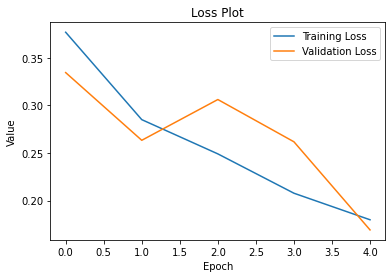

In [77]:
# Loss training and validation
from matplotlib import pyplot as plt

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Plot')
plt.ylabel('Value')
plt.xlabel('Epoch')
plt.legend(loc="upper right")
plt.show()

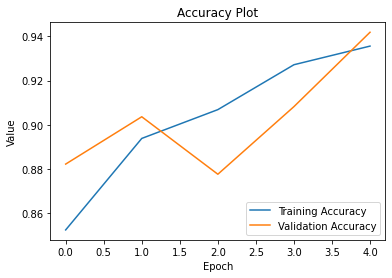

In [78]:
# Accuracy training & validation
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Plot')
plt.ylabel('Value')
plt.xlabel('Epoch')
plt.legend(loc="lower right")
plt.show()

Saving 01E392EE-69F9-4E33-BFCE-E5C968654078-copy1 (20).jpeg to 01E392EE-69F9-4E33-BFCE-E5C968654078-copy1 (20).jpeg
01E392EE-69F9-4E33-BFCE-E5C968654078-copy1 (20).jpeg
Covid


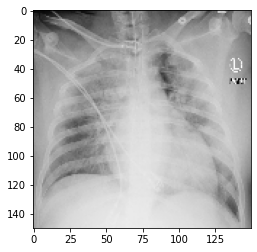

In [79]:
import numpy as np
from google.colab import files
from keras.preprocessing import image
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

uploaded = files.upload()

for fn in uploaded.keys():

  path = fn 
  img = image.load_img(path, target_size =(150,150))
  imgplot = plt.imshow(img)
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)

  images = np.vstack([x])
  classes = model.predict(images, batch_size=10)

  print(fn)
  if classes[0,0]!=0:
    print('Covid')
  elif classes[0,1]!=0:
    print('Normal')
  else:
    print('Pneumonia')

In [80]:

# Converting a SavedModel to a TensorFlow Lite model.
converter = tf.lite.TFLiteConverter.from_saved_model(checkpoint_filepath)
tflite_model = converter.convert()
            
# Save the model.
with open('model.tflite', 'wb') as f:
  f.write(tflite_model)
